In [30]:
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt

# import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.TNF import *
from nf.models import NormalizingFlowModel

from tensorboardX import SummaryWriter

from shapely.geometry import Point, Polygon

In [31]:
def StableVariable(m, alpha):
     V = np.pi/2 * (2*np.random.rand(m)-1)
     W = np.random.exponential(scale=1, size=m)
     y = np.sin(alpha * V) / (np.cos(V)**(1/alpha) ) * (np.cos( V*(1-alpha)) / W )**((1-alpha)/alpha)
     return y

def GeneratingData(T, dt, n_samples):
    t = np.arange(0, T, dt)
    
    Nt = len(t)
    # #multimodal initial distribution
    # mu = np.array([[2, 3]])
    # sigma = np.eye(2)
    # X0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    # XX0 = 1*np.random.multivariate_normal(mu[0],sigma,250)  + 0.5*np.random.multivariate_normal(-mu[0],sigma,250)
    
    
    #single-model initial distribution
    X0 = np.random.randn(n_samples//2,2)
    XX0 = np.random.randn(n_samples//2,2)
    
    # #fixed initial value
    # X0 = np.ones([n_samples//2,2])
    # XX0 = np.ones([n_samples//2,2])   
    
    
    x0 = X0[:,0:1]
    xx0 = XX0[:,0:1]
    y0 = X0[:,1:]
    yy0 = XX0[:,1:]
    N = len(x0) + len(xx0)
    alpha = 1.5
    x = np.zeros((Nt, N))
    y = np.zeros((Nt, N))
    x[0, 0:n_samples//2] = x0.squeeze()
    x[0, n_samples//2:n_samples] = xx0.squeeze()
    y[0, 0:n_samples//2] = y0.squeeze()
    y[0, n_samples//2:n_samples] = yy0.squeeze()
    for i in range(Nt-1):
        Ut = dt**(1/alpha) * StableVariable(N, alpha)
        Vt = dt**(1/alpha) * StableVariable(N, alpha)
        UUt = dt**(1/2) * np.random.randn(N)
        VVt = dt**(1/2) * np.random.randn(N)
        # #Multimodal case
        # x[i+1, :] = x[i, :] + (8*x[i, :] - 1*x[i, :]**3)*dt + 0*x[i, :]*UUt+ 1*UUt
        # y[i+1, :] = y[i, :] + (8*y[i, :] - 1*y[i, :]**3)*dt + 0*y[i, :]*VVt + 1*VVt
        
        # #Unimodal case
        x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
        y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
     
        b=np.empty(0).astype(int)
        for j in range(n_samples):
            if (np.abs(x[:,j])>1e4).any() or (np.abs(y[:,j])>1e4).any():
                b = np.append(b,j)
        x1 = np.delete(x,b,axis=1)
        y1 = np.delete(y,b,axis=1)
    print('shape of x1', x1.shape)
    print('shape of y1', y1.shape)
    print('shape of t', t.shape)
    return t, x1, y1

In [32]:
# #Estimating baseline density 
def sample2density(x, u, v, du, dv):
    m, n = u.shape
    l, s =x.shape
    count = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            for k in range(l):
                if x[k,0]>=u[i,j]- du/2 and x[k,0]<u[i,j] + du/2 and x[k,1]>=v[i,j]- dv/2 and x[k,1]<v[i,j]+ dv/2:
                    count[i,j] += 1
    return count/(l*du*dv)


def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], s=1, marker="o", **kwargs)
    # #Unimodal case
    # plt.xlim((-5, 5))
    # plt.ylim((-20, 20))
    
    # #Multimodal case
    # plt.xlim((-8, 8))
    # plt.ylim((-8, 8))
    plt.xlabel("x")
    plt.ylabel("y")


In [33]:
argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=1, type=int)
argparser.add_argument("--flow", default="RealNVP", type=str)
argparser.add_argument("--iterations", default=5000, type=int)
argparser.add_argument("--use-mixture", action="store_true")
argparser.add_argument("--convolve", action="store_true")
argparser.add_argument("--actnorm", action="store_true")
args = argparser.parse_args(args=[]) 
logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=2) for _ in range(args.flows)]
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
model = NormalizingFlowModel(prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.005)
T = 1
dt = 0.05
time, position_x, position_y = GeneratingData(T, dt, 500)

shape of x1 (20, 480)
shape of y1 (20, 480)
shape of t (20,)


/tmp/ipykernel_7413/1260369468.py:49: RuntimeWarning: overflow encountered in power
  x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
/tmp/ipykernel_7413/1260369468.py:50: RuntimeWarning: overflow encountered in multiply
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
/tmp/ipykernel_7413/1260369468.py:49: RuntimeWarning: invalid value encountered in subtract
  x[i+1, :] = x[i, :] + 1*(4*x[i, :] - 1*x[i, :]**3)*dt + x[i, :]*Ut
/tmp/ipykernel_7413/1260369468.py:50: RuntimeWarning: invalid value encountered in add
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt
/tmp/ipykernel_7413/1260369468.py:50: RuntimeWarning: invalid value encountered in subtract
  y[i+1, :] = y[i, :] - x[i, :]*y[i, :]*dt + y[i, :]*Vt


In [34]:
t = np.repeat(time, position_x.shape[1]).reshape(-1, 1)
P_x = np.reshape(position_x, position_x.size, order='C').reshape(-1, 1)
P_y = np.reshape(position_y, position_y.size, order='C').reshape(-1, 1)
x = torch.Tensor(np.concatenate((P_x,P_y,t),axis=1))

print('shape of x', x.shape)

# write to file
with open('data.txt', 'w') as f:
    for i in range(x.shape[0]):
        f.write(str(x[i,0].item()) + '\t' + str(x[i,1].item()) + '\t' + str(x[i,2].item()) + '\n')

shape of x torch.Size([9600, 3])


In [35]:
# read the hull points from file
with open('hull_points.txt', 'r') as f:
    lines = f.readlines()
    cell_coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        cell_coords[i,0] = float(line[0])
        cell_coords[i,1] = float(line[1])

print(cell_coords)

[[180.53   57.143]
 [202.66   62.833]
 [216.36   71.84 ]
 [217.04   72.704]
 [238.2   104.87 ]
 [244.95  117.91 ]
 [265.88  169.38 ]
 [281.13  241.8  ]
 [269.9   266.66 ]
 [262.4   280.56 ]
 [258.24  284.44 ]
 [230.25  305.39 ]
 [206.04  320.03 ]
 [193.17  320.   ]
 [188.06  317.96 ]
 [148.75  302.1  ]
 [148.07  300.98 ]
 [ 99.647 219.18 ]
 [ 89.752 185.29 ]
 [ 87.991 150.96 ]
 [ 87.878 138.36 ]
 [ 90.066 130.7  ]
 [ 96.688 107.73 ]
 [100.67  103.52 ]
 [124.98   78.969]
 [134.42   72.657]]


In [36]:
cutoff = 20
numchosen = 89
newx = np.zeros((cutoff*numchosen,3))
# read from file the first, second, and fourth columns
with open('new_traj_frame_wise.txt', 'r') as f:
    for i in range(cutoff*numchosen):
        line = f.readline()
        line = line.split('\t')
        newx[i,0] = float(line[0])
        newx[i,1] = float(line[1])
        newx[i,2] = float(line[3])
# newx = torch.Tensor(newx)
print('shape of newx', newx.shape)

# add points outside the hull
# sample from a uniform distribution between (0,0) and (600,600) and add them if they are outside the hull 
# add 100 points
# for i in range(100):
#     x = np.random.uniform(0, 450, 2)
#     point = Point(x)
#     if not Polygon(cell_coords).contains(point):
#         toAdd = np.zeros((20,3))
#         toAdd[:,0] = x[0]
#         toAdd[:,1] = x[1]
#         toAdd[:,2] = np.linspace(0, 0.95, 20)
#         newx = np.concatenate((newx, toAdd), axis=0)
#         numchosen += 1

newx = torch.Tensor(newx)
print('shape of newx', newx.shape)

x = newx

shape of newx (1780, 3)
shape of newx torch.Size([1780, 3])


In [37]:
isInisde = np.zeros((x.shape[0],1))
print('shape of isInisde', isInisde.shape)

cell_polygon = Polygon(cell_coords)
for i in range(x.shape[0]):
    point = Point(x[i,0].item(), x[i,1].item())
    isInisde[i] = cell_polygon.contains(point)

# convert to tensor
isInisde = torch.Tensor(isInisde)


shape of isInisde (1780, 1)


In [38]:
writer = SummaryWriter('2Duni')
Loss = np.zeros([args.iterations, 1])
for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det, px = model(x)
    logprob = prior_logprob + log_det
    # temp = logprob - 1e7*(1-isInisde)
    temp = logprob
    loss = -torch.mean(temp)
    loss.backward()
    optimizer.step()
    Loss[i] = loss.detach().numpy()
    writer.add_scalar('Loss', loss.item(), i)
writer.close()
np.save('2Dloss_Ex1.npy',Loss)

Loss at iteration 0: 44895.68359375
Loss at iteration 1: 7754.2177734375
Loss at iteration 2: 2290.036376953125
Loss at iteration 3: 904.4375610351562
Loss at iteration 4: 430.42694091796875
Loss at iteration 5: 235.15896606445312
Loss at iteration 6: 144.18084716796875
Loss at iteration 7: 98.84710693359375
Loss at iteration 8: 76.85694885253906
Loss at iteration 9: 68.02534484863281
Loss at iteration 10: 64.96720123291016
Loss at iteration 11: 61.5810661315918
Loss at iteration 12: 54.92470932006836
Loss at iteration 13: 45.66147994995117
Loss at iteration 14: 36.29204559326172
Loss at iteration 15: 28.85820960998535
Loss at iteration 16: 23.936925888061523
Loss at iteration 17: 21.075368881225586
Loss at iteration 18: 19.568035125732422
Loss at iteration 19: 18.829679489135742
Loss at iteration 20: 18.491966247558594
Loss at iteration 21: 18.35540008544922
Loss at iteration 22: 18.312837600708008
Loss at iteration 23: 18.306621551513672
Loss at iteration 24: 18.305789947509766
Loss 

KeyboardInterrupt: 

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/prani/.local/lib/python3.10/site-packages/matplotlib/mpl-da

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBold.ttf', name='Yrsa', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Sarai/Sarai.ttf', name='Sarai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-orya-extra/utkal.ttf', na

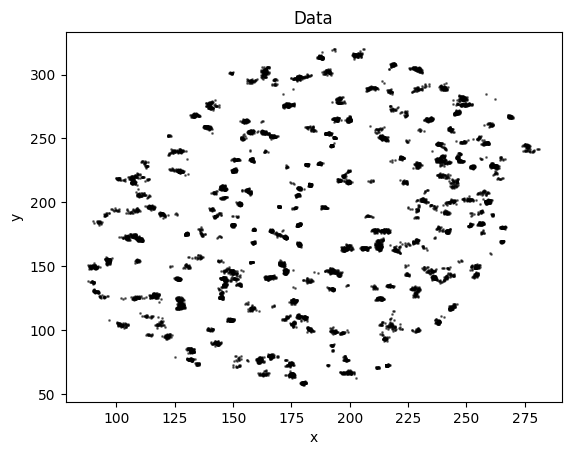

In [ ]:
# load all the data from file
with open('20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt', 'r') as f:
    lines = f.readlines()
    coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        coords[i,0] = float(line[2])
        coords[i,1] = float(line[3])

# plot the data
plt.figure()
# plot all points
plt.plot(coords[:,0], coords[:,1], 'o', color='black', markersize=1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()

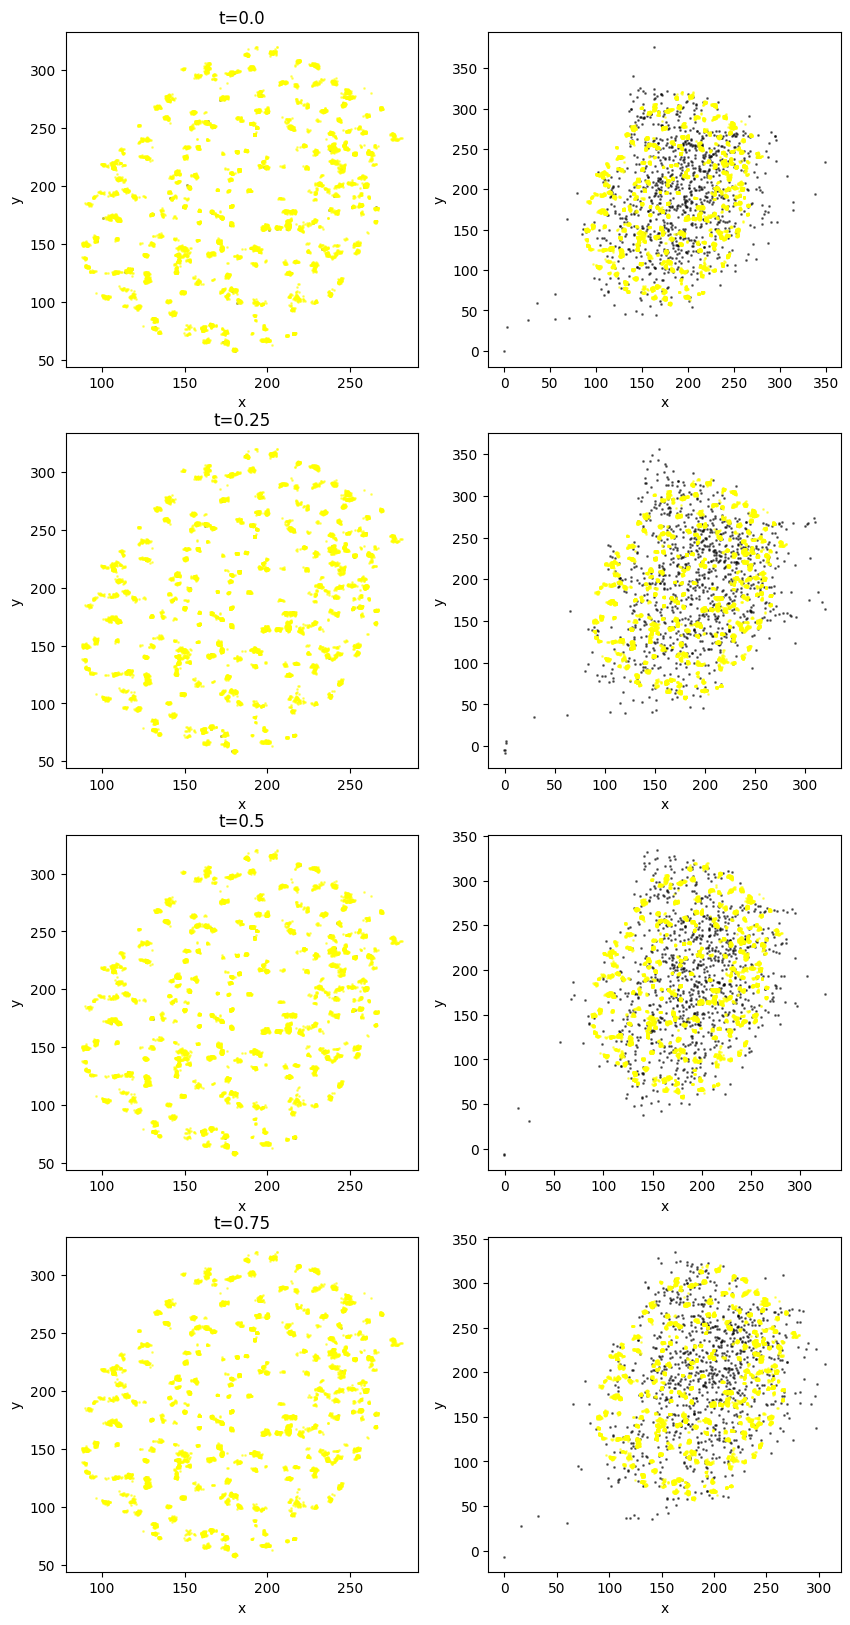

In [ ]:
position_x = np.reshape(x[:,0].detach().numpy(), (cutoff, numchosen), order='C')
position_y = np.reshape(x[:,1].detach().numpy(), (cutoff, numchosen), order='C')

# Resampling
plt.figure(figsize=(10,20))
plt.subplot(4, 2, 1)
xxx = np.concatenate((position_x[0:1,:].T, position_y[0:1,:].T), axis=1)
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(xxx, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.0")

plt.subplot(4, 2, 3)
xxx = np.concatenate((position_x[5:6,:].T, position_y[5:6,:].T), axis=1)
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(xxx, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.25")

plt.subplot(4, 2, 5)
xxx = np.concatenate((position_x[10:11,:].T, position_y[10:11,:].T), axis=1)
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(xxx, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.5")

plt.subplot(4, 2, 7)
xxx = np.concatenate((position_x[15:16,:].T, position_y[15:16,:].T), axis=1)
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(xxx, color="black", alpha=0.3)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.75")

plt.subplot(4, 2, 2)
samples = model.sample(1000, t=0).data
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(samples, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
# plt.title("t=0.0")

plt.subplot(4, 2, 4)
samples = model.sample(1000, t=0.25).data
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(samples, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
# plt.title("t=0.25")

plt.subplot(4, 2, 6)
samples = model.sample(1000, t=0.5).data
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(samples, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
# plt.title("t=0.5")

plt.subplot(4, 2, 8)
samples = model.sample(1000, t=0.75).data
plt.plot(coords[:,0], coords[:,1], 'o', color='yellow', markersize=1, alpha=0.5)
plot_data(samples, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
# plt.title("t=0.75")
plt.show()